# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data

In [113]:
df = pd.read_csv("BTCUSDT_price_data_2024-01-24-2.csv")
df["timestamp"] = df["timestamp"].astype(str).str.replace(r"[^0-9]", "", regex=True)
df["timestamp"] = df["timestamp"].astype(float) / 1000
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.set_index("datetime")
df.head()

,timestamp,mid_price,volume
datetime,,,
2024-01-24 00:00:00,1.706054e+09,39881.95,439.561
2024-01-24 00:01:00,1.706054e+09,39926.55,776.492
2024-01-24 00:02:00,1.706055e+09,39877.05,339.306
2024-01-24 00:03:00,1.706055e+09,39927.45,246.511
2024-01-24 00:04:00,1.706055e+09,39926.55,423.920


## Task 1

In [114]:
df["p_t_minus_1"] = df["mid_price"].shift(1)
df["asset_return"] = ((df["mid_price"] - df["p_t_minus_1"]) / df["p_t_minus_1"]).fillna(0.0)

## Task 2

In [115]:
window = 10
df["sma_10"] = df["mid_price"].rolling(window=window).mean()

## Task 3

In [116]:
df["signal"] = 0
df.loc[df["mid_price"] > df["sma_10"], "signal"] = 1
df.loc[df["mid_price"] < df["sma_10"], "signal"] = -1

In [118]:
df

,timestamp,mid_price,volume,p_t_minus_1,asset_return,sma_10,signal
datetime,,,,,,,
2024-01-24 00:00:00,1.706054e+09,39881.95,439.561,NaN,0.000000,NaN,0
2024-01-24 00:01:00,1.706054e+09,39926.55,776.492,39881.95,0.001118,NaN,0
2024-01-24 00:02:00,1.706055e+09,39877.05,339.306,39926.55,-0.001240,NaN,0
2024-01-24 00:03:00,1.706055e+09,39927.45,246.511,39877.05,0.001264,NaN,0
2024-01-24 00:04:00,1.706055e+09,39926.55,423.920,39927.45,-0.000023,NaN,0
...,...,...,...,...,...,...,...
2024-01-24 23:54:00,1.706140e+09,40136.15,143.443,40112.05,0.000601,40140.405,-1
2024-01-24 23:55:00,1.706140e+09,40098.15,186.484,40136.15,-0.000947,40137.620,-1
2024-01-24 23:56:00,1.706141e+09,40088.35,190.487,40098.15,-0.000244,40131.630,-1


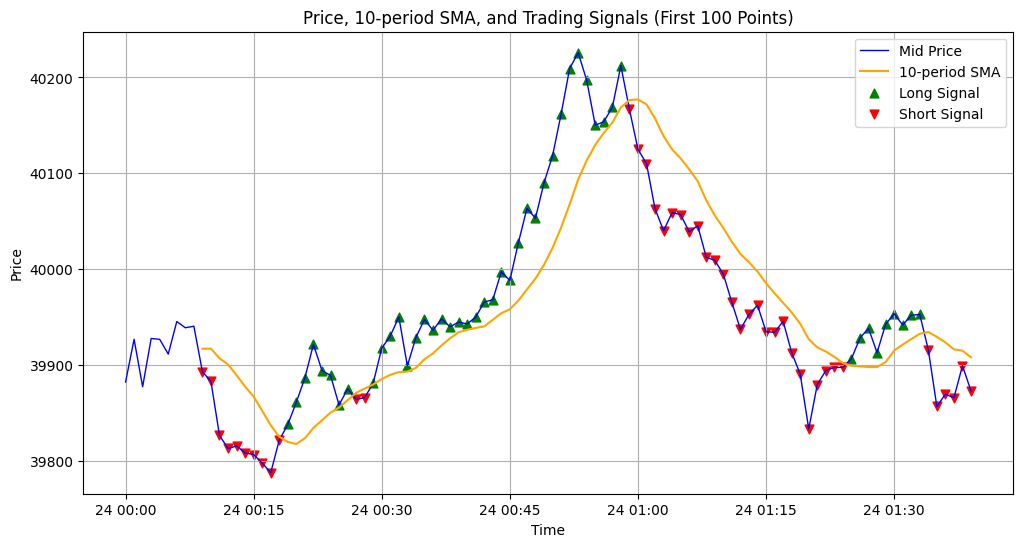

In [119]:
# --- Plot: Price, SMA, and Trading Signals (first 100 points) ---

subset = df.iloc[:100]

plt.figure(figsize=(12, 6))

plt.plot(subset.index, subset["mid_price"], label="Mid Price", color="blue", linewidth=1)
plt.plot(subset.index, subset["sma_10"], label="10-period SMA", color="orange", linewidth=1.5)

# Mark long and short signals
long_signals = subset[subset["signal"] == 1]
short_signals = subset[subset["signal"] == -1]

plt.scatter(long_signals.index, long_signals["mid_price"], label="Long Signal", color="green", marker="^", s=40)
plt.scatter(short_signals.index, short_signals["mid_price"], label="Short Signal", color="red", marker="v", s=40)

plt.title("Price, 10-period SMA, and Trading Signals (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Task 4 - 5

In [104]:
def backtest_strategy(df, sma_col="sma_10", price_col="mid_price", signal_col="signal", initial_capital=100_000.0):
    """
    Simulate the simple SMA trading strategy.

    Parameters
    ----------
    df : pd.DataFrame
        Data containing at least columns for price and SMA.
    sma_col : str, default "sma_10"
        Name of the SMA column to use for signals.
    price_col : str, default "mid_price"
        Name of the column containing prices.
    initial_capital : float, default 100_000
        Starting capital in USD.

    Returns
    -------
    df_out : pd.DataFrame
        Copy of input DataFrame with columns added:
            - position
            - strategy_return
            - equity
        and summary statistics printed to screen.
    """

    df = df.copy()

    # --- 1. Determine long/short signals ---
    raw_signal = df[signal_col]

    # Forward fill positions and remain flat until SMA exists
    df["position"] = raw_signal.replace(0, np.nan).ffill().fillna(0.0)

    # --- 3. Compute strategy returns (using previous position) ---
    df["strategy_return"] = df["position"].shift(1).fillna(0.0) * df["asset_return"]

    # --- 4. Compute equity curve ---
    df["equity"] = (1 + df["strategy_return"]).cumprod() * initial_capital

    # --- 5. Compute performance metrics ---
    trades = int((df["position"].diff().abs() > 0).sum())
    total_return_pct = (df["equity"].iloc[-1] / initial_capital - 1.0) * 100.0
    max_equity = df["equity"].cummax()
    drawdown = df["equity"] / max_equity - 1.0
    max_drawdown_pct = drawdown.min() * 100.0
    
        # Sharpe ratio annualized from one minute returns
    rets = df["strategy_return"].dropna()
    mu = rets.mean()
    sigma = rets.std(ddof=0)
    minutes_per_year=365*24*60
    if sigma == 0 or np.isnan(sigma):
        sharpe = np.nan
    else:
        sharpe = float((mu / sigma) * np.sqrt(minutes_per_year))

    print(f"Final equity: ${df['equity'].iloc[-1]:,.2f}")
    print(f"Total return: {total_return_pct:.2f}%")
    print(f"Max drawdown: {max_drawdown_pct:.2f}%")
    print(f"Number of trades: {trades}")
    print(f'Sharpe ratio {sharpe}')

    return df


In [125]:
import numpy as np
import pandas as pd

def backtest_strategy(
    df,
    sma_col="sma_10",
    price_col="mid_price",
    signal_col="signal",
    initial_capital=100_000.0,
    allow_short_enter=False
):
    """
    Simulate the simple SMA trading strategy, with control over whether the very first
    entry is allowed to be short or not.

    Parameters
    ----------
    df : pd.DataFrame
        Data containing at least columns for price and SMA derived signal.
    sma_col : str
        Column name for SMA, kept for context.
    price_col : str
        Column name for price.
    signal_col : str
        Column name for precomputed signal, where +1 is long and -1 is short.
    initial_capital : float
        Starting capital in USD.
    allow_short_enter : bool
        If False, the strategy will remain flat until the first long signal appears.
        If True, the strategy may enter short on the first valid signal if it is -1.
    """

    df = df.copy()

    # Use provided signals and create a filled version that persists until a flip
    raw_signal = df[signal_col].astype(float)
    signal_filled = raw_signal.replace(0, np.nan).ffill()

    # Build position with an in position flag and the allow_short_enter rule
    position = []
    in_position = False
    current_pos = 0.0

    for s in signal_filled:
        if pd.isna(s) or s == 0:
            # No new information, hold if already in, otherwise stay flat
            pos = current_pos if in_position else 0.0

        else:
            if not in_position:
                # First possible entry
                if s == -1.0 and not allow_short_enter:
                    # Do not allow initial short entry, stay flat
                    pos = 0.0
                    # remain out of market
                else:
                    # Enter with the first valid side
                    current_pos = float(s)
                    in_position = True
                    pos = current_pos
            else:
                # Already in a position, flip only when side changes
                if s != current_pos:
                    current_pos = float(s)
                pos = current_pos

        position.append(pos)

    df["position"] = position

    # Compute asset returns
    df["asset_return"] = df[price_col].pct_change().fillna(0.0)

    # Strategy returns use the position held over the interval
    df["strategy_return"] = df["position"].shift(1).fillna(0.0) * df["asset_return"]

    # Equity curve
    df["equity"] = (1.0 + df["strategy_return"]).cumprod() * initial_capital


    # Metrics
    trades = int((df["position"].diff().abs() > 0).sum())
    total_return_pct = (df["equity"].iloc[-1] / initial_capital - 1.0) * 100.0
    max_equity = df["equity"].cummax()
    drawdown = df["equity"] / max_equity - 1.0
    max_drawdown_pct = drawdown.min() * 100.0
    
    rets = df["strategy_return"].dropna()
    mu = rets.mean()
    sigma = rets.std(ddof=0)
    minutes_per_year=365*24*60
    if sigma == 0 or np.isnan(sigma):
        sharpe = np.nan
    else:
        sharpe = float((mu / sigma) * np.sqrt(minutes_per_year))

    print('Simulation')
    print(f'Initial capital: ${initial_capital:,.2f}')
    print(f"Allow short enter: {allow_short_enter}")
    print('Results \n ------')
    print(f"Final equity: ${df['equity'].iloc[-1]:,.2f}")
    print(f"Total return: {total_return_pct:.2f}%")
    print(f"Max drawdown: {max_drawdown_pct:.2f}%")
    print(f"Number of trades: {trades}")
    print(f'Sharpe ratio {sharpe}')
    

    return df


In [135]:
results = backtest_strategy(df,allow_short_enter=True)

Simulation
Initial capital: $100,000.00
Allow short enter: True
Results 
 ------
Final equity: $102,585.49
Total return: 2.59%
Max drawdown: -2.06%
Number of trades: 225
Sharpe ratio 21.026622685863547


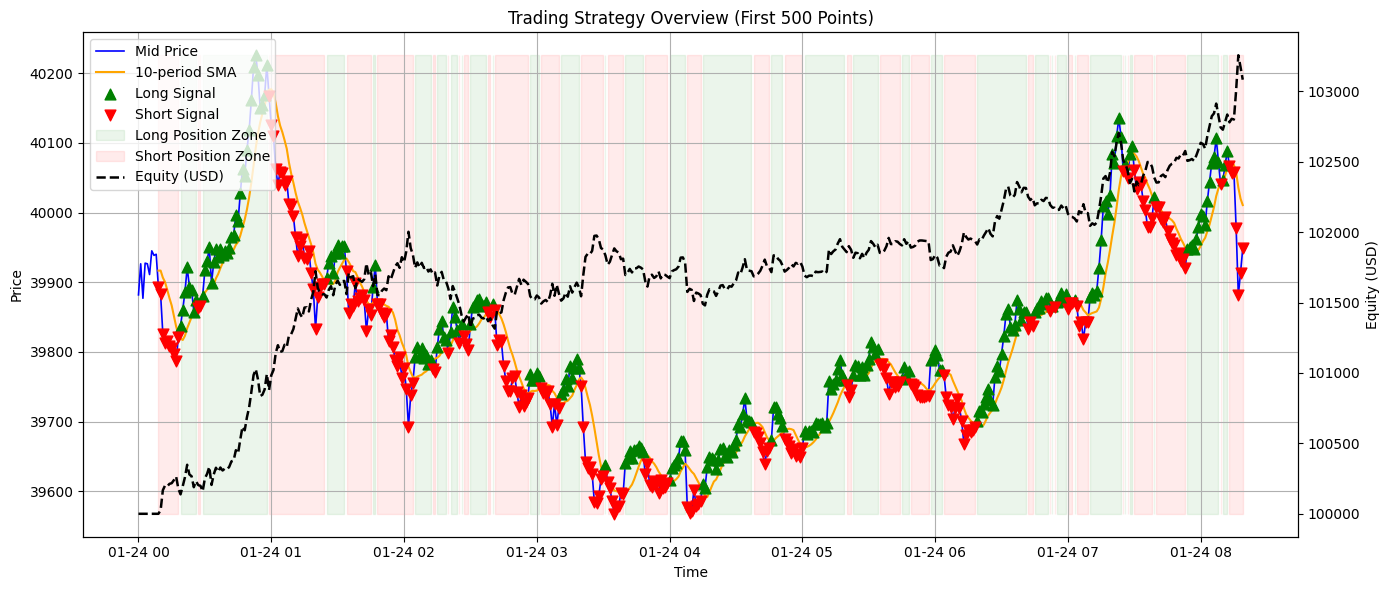

In [137]:
import matplotlib.pyplot as plt

# --- Combined Plot: Price, SMA, Trading Signals, Position, and Equity ---
N_points = 500
subset = results.iloc[:N_points]  # or use results_df if you renamed after backtest

fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Price and SMA on the primary y-axis ---
ax1.plot(subset.index, subset["mid_price"], label="Mid Price", color="blue", linewidth=1.2)
ax1.plot(subset.index, subset["sma_10"], label="10-period SMA", color="orange", linewidth=1.5)

# --- Mark trading signals ---
long_signals = subset[subset["signal"] == 1]
short_signals = subset[subset["signal"] == -1]

ax1.scatter(long_signals.index, long_signals["mid_price"],
            label="Long Signal", color="green", marker="^", s=60, zorder=5)
ax1.scatter(short_signals.index, short_signals["mid_price"],
            label="Short Signal", color="red", marker="v", s=60, zorder=5)

# --- Plot position as shaded regions (long/short zones) ---
ax1.fill_between(subset.index, subset["mid_price"].min(), subset["mid_price"].max(),
                 where=subset["position"] > 0, color="green", alpha=0.08, label="Long Position Zone")
ax1.fill_between(subset.index, subset["mid_price"].min(), subset["mid_price"].max(),
                 where=subset["position"] < 0, color="red", alpha=0.08, label="Short Position Zone")

# --- Secondary y-axis for equity curve ---
ax2 = ax1.twinx()
ax2.plot(subset.index, subset["equity"], label="Equity (USD)", color="black", linewidth=1.8, linestyle="--")

# --- Labels and title ---
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax2.set_ylabel("Equity (USD)")

ax1.set_title(f"Trading Strategy Overview (First {N_points} Points)")
ax1.grid(True)

# --- Handle legends from both axes ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

plt.tight_layout()
plt.show()


# Task 6

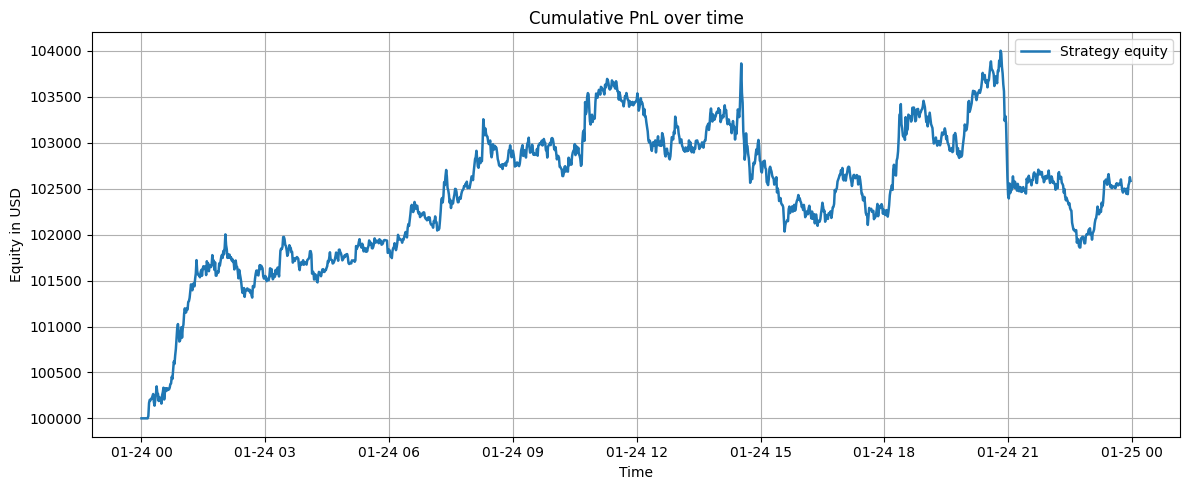

In [139]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, results["equity"], label="Strategy equity", linewidth=1.8)
ax.set_title("Cumulative PnL over time")
ax.set_xlabel("Time")
ax.set_ylabel("Equity in USD")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Task 7

In [ ]:
import numpy as np
import pandas as pd

def backtest_strategy(
    df,
    sma_col="sma_10",
    price_col="mid_price",
    signal_col="signal",
    initial_capital=100_000.0,
    allow_short_enter=False,
    transaction_cost_pct=0.0002  # 0.02% per side
):
    """
    Simulate the SMA strategy with optional control of the first entry side and
    realistic transaction costs applied per side.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain price, SMA derived signal, and an index in time order.
    sma_col : str
        Column name for SMA. Kept for context.
    price_col : str
        Column name for price.
    signal_col : str
        Column name for precomputed signal where +1 is long and -1 is short.
    initial_capital : float
        Starting capital in USD.
    allow_short_enter : bool
        If False, remain flat until the first long appears. If True, may start short.
    transaction_cost_pct : float
        Proportional cost per executed side. For example 0.0002 equals 0.02 percent.
    """

    df = df.copy()

    # Use provided signals and create a filled version that persists until a flip
    raw_signal = df[signal_col].astype(float)
    signal_filled = raw_signal.replace(0, np.nan).ffill()

    # Build position with an in position flag and the allow_short_enter rule
    position = []
    in_position = False
    current_pos = 0.0

    for s in signal_filled:
        if pd.isna(s) or s == 0:
            pos = current_pos if in_position else 0.0
        else:
            if not in_position:
                if s == -1.0 and not allow_short_enter:
                    pos = 0.0
                else:
                    current_pos = float(s)
                    in_position = True
                    pos = current_pos
            else:
                if s != current_pos:
                    current_pos = float(s)
                pos = current_pos
        position.append(pos)

    df["position"] = position

    # Compute asset returns
    df["asset_return"] = df[price_col].pct_change().fillna(0.0)

    # Strategy returns from the position held over the interval
    df["strategy_return_gross"] = df["position"].shift(1).fillna(0.0) * df["asset_return"]

    # Transaction costs per bar
    # Count executed sides from position changes
    # Entry from 0 to +1 or -1 counts as 1 side
    # Flip from +1 to -1 or reverse counts as 2 sides
    pos_diff = df["position"].diff().fillna(0.0).abs()
    executed_sides = pos_diff  # values are 0, 1, or 2 with positions in {-1, 0, +1}
    df["tx_cost"] = executed_sides * transaction_cost_pct

    # Net strategy return after costs
    df["strategy_return"] = df["strategy_return_gross"] - df["tx_cost"]

    # Equity curve
    df["equity"] = (1.0 + df["strategy_return"]).cumprod() * initial_capital

    # Metrics
    trades = int((pos_diff > 0).sum())
    total_return_pct = (df["equity"].iloc[-1] / initial_capital - 1.0) * 100.0
    max_equity = df["equity"].cummax()
    drawdown = df["equity"] / max_equity - 1.0
    max_drawdown_pct = drawdown.min() * 100.0

    rets = df["strategy_return"].dropna()
    mu = rets.mean()
    sigma = rets.std(ddof=0)
    minutes_per_year = 365 * 24 * 60
    if sigma == 0 or np.isnan(sigma):
        sharpe = np.nan
    else:
        sharpe = float((mu / sigma) * np.sqrt(minutes_per_year))

    print("Simulation")
    print(f"Initial capital: ${initial_capital:,.2f}")
    print(f"Allow short enter: {allow_short_enter}")
    print(f"Transaction cost per side: {transaction_cost_pct*100:.4f}%")
    print("Results")
    print("------")
    print(f"Final equity: ${df['equity'].iloc[-1]:,.2f}")
    print(f"Total return: {total_return_pct:.2f}%")
    print(f"Max drawdown: {max_drawdown_pct:.2f}%")
    print(f"Number of trades: {trades}")
    print(f"Sharpe ratio: {sharpe}")

    return df


# End

In [33]:
df.head()

,timestamp,mid_price,volume,p_t_minus_1,r_t,sma_10,signal,signal_shifted,r_t_strategy
datetime,,,,,,,,,
2024-01-24 00:00:00,1.706054e+09,39881.95,439.561,NaN,NaN,NaN,0,NaN,NaN
2024-01-24 00:01:00,1.706054e+09,39926.55,776.492,39881.95,0.001118,NaN,0,0.0,0.0
2024-01-24 00:02:00,1.706055e+09,39877.05,339.306,39926.55,-0.001240,NaN,0,0.0,-0.0
2024-01-24 00:03:00,1.706055e+09,39927.45,246.511,39877.05,0.001264,NaN,0,0.0,0.0
2024-01-24 00:04:00,1.706055e+09,39926.55,423.920,39927.45,-0.000023,NaN,0,0.0,-0.0
